In [2]:
# This is the initial take of pulling the MNIST CBIR from https://blog.sicara.com/keras-tutorial-content-based-image-retrieval-convolutional-denoising-autoencoder-dc91450cc511
#    and making it work in a Jupyter notebook for unrotated pill images.



In [3]:
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [124]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14617519507204532639
]


In [5]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

## Train model

In [7]:
#target_image_size = (64,112)
#target_image_size_3D = (64,112,1)

target_image_size = (32,64)
target_image_size_3D = (32,64,1)

In [8]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


# For training
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [9]:
def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

In [10]:
# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        'data_with_rotations/train',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='grayscale')

validation_generator = validation_datagen.flow_from_directory(
        'data_with_rotations/validate',
        target_size=target_image_size,
        batch_size=32,
        class_mode='input',
        color_mode='grayscale')



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.
1


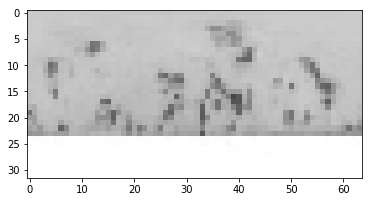

In [11]:
# Get 16 sample images to use throughout all the training for visualization
# Load Test images to generate testing data
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode='grayscale')

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

print(np.shape(ti)[-1])

display_image(test_image)

#test_display = np.concatenate((ti,ti,ti), axis=2)

#plt.imshow(test_display)

#plt.show()


In [12]:
len(test_image[:,:,0])
np.shape(sample_images)

(16, 32, 64, 1)

In [13]:
def define_model():
    
    big_conv = (7,7)
    num_conv = 128
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2,2))(input_img)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)

    # Layer 30

#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    
    #autoencoder.fit_generator(
    #    train_generator,
    #    steps_per_epoch=2000,
    #    epochs=10,
    #    validation_data=validation_generator,
    #    validation_steps=800)
        #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])
    
    # autoencoder.save('autoencoder_pill.h5')



In [14]:
class ProgressCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #print('epoch ended')
        #print(self.model)
        
        processed_images = self.model.predict(x=sample_images,batch_size=16)
         
        
        # plot the image
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(sample_images[0])
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        plt.show()


In [15]:


def train_model(model_to_train):
    progress = ProgressCallback()
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=100,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save('autoencoder.h5')
    
    return model_to_train

In [16]:
#autoencoder.save('autoencoder_8by14by128.h5')

In [17]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded/Sigmoid:0' shape=(?, 32, 64, 1) dtype=float32>]


In [18]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 32, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 16, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 16, 128)        36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 8, 128)         147584    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 16, 128)        0         
__________

In [19]:
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder/MaxPool:0' shape=(?, 4, 8, 128) dtype=float32>

In [20]:
progress = ProgressCallback()

In [143]:
#autoencoder = x
autoencoder = train_model(autoencoder)

Epoch 1/5
200/200 [==============================] - 15s 74ms/step - loss: 0.4930 - val_loss: 0.4689
Epoch 2/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4923 - val_loss: 0.4692
Epoch 3/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4931 - val_loss: 0.4689
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4926 - val_loss: 0.4688
Epoch 5/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4924 - val_loss: 0.4691


In [24]:
#!pip3 install jupyter-tensorboard
for i in range(3):
    #pass
    autoencoder = train_model(x)

Epoch 1/5
200/200 [==============================] - 13s 67ms/step - loss: 0.5096 - val_loss: 0.4896
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.5020 - val_loss: 0.4772
Epoch 3/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4996 - val_loss: 0.4758
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4976 - val_loss: 0.4737
Epoch 5/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4973 - val_loss: 0.4736
Epoch 1/5
200/200 [==============================] - 14s 71ms/step - loss: 0.4969 - val_loss: 0.4746
Epoch 2/5
200/200 [==============================] - 15s 74ms/step - loss: 0.4959 - val_loss: 0.4725
Epoch 3/5
200/200 [==============================] - 15s 73ms/step - loss: 0.4956 - val_loss: 0.4723
Epoch 4/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4954 - val_loss: 0.4713
Epoch 5/5
200/200 [==============================] - 14s 71ms/step - loss: 0.4949 - val_los

In [25]:
#!pip3 install jupyter-tensorboard
for i in range(10):
    #autoencoder = train_model(x)
    pass

In [144]:
for i in range(50):
    #autoencoder = train_model(x)
    #pass

Epoch 1/5
200/200 [==============================] - 15s 73ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 2/5
200/200 [==============================] - 15s 73ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 3/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4933 - val_loss: 0.4692
Epoch 4/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4923 - val_loss: 0.4688
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 1/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4928 - val_loss: 0.4687
Epoch 2/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4924 - val_loss: 0.4688
Epoch 3/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4921 - val_loss: 0.4689
Epoch 4/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4927 - val_loss: 0.4689
Epoch 5/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4923 - val_los

200/200 [==============================] - 14s 69ms/step - loss: 0.4902 - val_loss: 0.4667
Epoch 3/5
200/200 [==============================] - 14s 70ms/step - loss: 0.4904 - val_loss: 0.4666
Epoch 4/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4902 - val_loss: 0.4667
Epoch 5/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4903 - val_loss: 0.4666
Epoch 1/5
200/200 [==============================] - 15s 74ms/step - loss: 0.4902 - val_loss: 0.4668
Epoch 2/5
200/200 [==============================] - 16s 78ms/step - loss: 0.4908 - val_loss: 0.4667
Epoch 3/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4898 - val_loss: 0.4669
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4907 - val_loss: 0.4666
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4900 - val_loss: 0.4666
Epoch 1/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4901 - val_loss: 0.4665


200/200 [==============================] - 13s 67ms/step - loss: 0.4894 - val_loss: 0.4662
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4897 - val_loss: 0.4662
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4896 - val_loss: 0.4664
Epoch 1/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4888 - val_loss: 0.4662
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4898 - val_loss: 0.4662
Epoch 3/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4896 - val_loss: 0.4661
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4900 - val_loss: 0.4661
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4894 - val_loss: 0.4661
Epoch 1/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4897 - val_loss: 0.4662
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4893 - val_loss: 0.4661


200/200 [==============================] - 16s 81ms/step - loss: 0.4890 - val_loss: 0.4660
Epoch 5/5
200/200 [==============================] - 16s 80ms/step - loss: 0.4891 - val_loss: 0.4660
Epoch 1/5
200/200 [==============================] - 16s 80ms/step - loss: 0.4894 - val_loss: 0.4660
Epoch 2/5
200/200 [==============================] - 16s 80ms/step - loss: 0.4889 - val_loss: 0.4660
Epoch 3/5
200/200 [==============================] - 16s 80ms/step - loss: 0.4894 - val_loss: 0.4661
Epoch 4/5
200/200 [==============================] - 16s 80ms/step - loss: 0.4892 - val_loss: 0.4661
Epoch 5/5
200/200 [==============================] - 16s 80ms/step - loss: 0.4892 - val_loss: 0.4660


## Test the model

In [145]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [146]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

scores = []

Loading model :
Model loaded in:  1.427778959274292


In [147]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=target_image_size,
                batch_size=self.batch_size,
                class_mode='input',
                color_mode='grayscale',
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames
        
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = self.test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



In [148]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)




In [149]:
dict = {}


test_images = all_directory_images_generator(batch_size=16)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        dict[names[j]]=encodings[j]
        


    
    

Found 96 images belonging to 1 classes.


In [150]:
import pandas as pd
df = pd.DataFrame.from_dict(dict, orient='index')
#df['filename'] = df.index
#df['image']= df['filename'].apply(lambda x: x.split('/')[-1])
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?
df.to_csv('96_images_32x64_AvgPool_4x8.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
images/229.jpg,0.145398,0.042797,0.413896,0.110306,0.136703,0.000000,0.218221,0.133094,0.271606,0.210855,...,0.001797,0.222250,0.246990,0.072358,0.000826,0.122546,0.253376,0.277861,0.278319,0.166817
images/229_196.jpg,0.150243,0.043915,0.422648,0.114121,0.142935,0.000000,0.196764,0.122383,0.260552,0.211222,...,0.001105,0.226690,0.267187,0.066092,0.001063,0.121114,0.242261,0.275193,0.265192,0.151258
images/229_262.jpg,0.162940,0.045791,0.430171,0.114764,0.138430,0.000000,0.207480,0.123207,0.256638,0.199773,...,0.003887,0.236447,0.245262,0.069996,0.000670,0.132164,0.247166,0.261768,0.288739,0.156620
images/229_45.jpg,0.146686,0.038133,0.416932,0.118317,0.136558,0.000000,0.203372,0.139753,0.280001,0.217100,...,0.003519,0.232575,0.263070,0.059130,0.000416,0.119272,0.256157,0.273170,0.278668,0.150071
images/230.jpg,0.174953,0.047712,0.338460,0.104342,0.137686,0.000000,0.155766,0.107589,0.272729,0.168639,...,0.002345,0.204625,0.222057,0.077154,0.002245,0.138129,0.244117,0.197012,0.194714,0.107904
images/230_200.jpg,0.179565,0.052044,0.346152,0.106924,0.128599,0.000000,0.152262,0.103621,0.291266,0.175684,...,0.001841,0.204707,0.199075,0.073321,0.002259,0.124715,0.263437,0.205326,0.191353,0.102231
images/230_287.jpg,0.168133,0.049731,0.354832,0.122513,0.128298,0.000000,0.148686,0.107718,0.287860,0.175760,...,0.003815,0.204929,0.214364,0.076125,0.001452,0.129648,0.269394,0.205156,0.204718,0.105121
images/230_341.jpg,0.178087,0.048166,0.348421,0.109211,0.133291,0.000000,0.146482,0.097596,0.257495,0.159884,...,0.003866,0.213084,0.211578,0.077485,0.002176,0.140864,0.248635,0.181213,0.184842,0.113855
images/231.jpg,0.229314,0.062925,0.376023,0.110000,0.149099,0.000000,0.125879,0.096027,0.249231,0.177572,...,0.000442,0.213956,0.221431,0.073530,0.003142,0.141057,0.260715,0.210246,0.193722,0.109694
images/231_212.jpg,0.213826,0.054111,0.376791,0.120488,0.146856,0.000000,0.134127,0.109645,0.260528,0.176891,...,0.001573,0.208223,0.214373,0.084941,0.002716,0.135029,0.267133,0.208379,0.180788,0.101859


In [151]:
dfstat = df.describe()
dfstat

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.155211,0.054146,0.366370,0.101321,0.119309,0.000323,0.202204,0.127134,0.260704,0.207566,...,0.002837,0.210531,0.241292,0.063295,0.000832,0.113275,0.237721,0.251774,0.276232,0.143669
std,0.042132,0.012325,0.042314,0.014692,0.015165,0.000699,0.039620,0.024350,0.014022,0.030983,...,0.001827,0.018164,0.018945,0.009270,0.000935,0.017983,0.018065,0.047499,0.043015,0.026235
min,0.088760,0.032230,0.248730,0.073157,0.081211,0.000000,0.096943,0.082065,0.224629,0.152988,...,0.000000,0.165392,0.193854,0.043136,0.000000,0.079167,0.190842,0.147885,0.166632,0.081782
25%,0.124453,0.044778,0.336757,0.091421,0.108970,0.000000,0.189372,0.107561,0.251272,0.178939,...,0.001681,0.200354,0.225178,0.056055,0.000000,0.100164,0.228256,0.220236,0.254255,0.130676
50%,0.154289,0.055807,0.373460,0.102090,0.117020,0.000000,0.218126,0.127878,0.260641,0.206255,...,0.002428,0.210456,0.243383,0.062387,0.000560,0.112896,0.237964,0.259804,0.279347,0.151990
75%,0.182247,0.063109,0.389134,0.110333,0.133336,0.000151,0.227267,0.144094,0.269419,0.228947,...,0.003623,0.222507,0.254961,0.069828,0.001450,0.127129,0.249780,0.288501,0.314410,0.161230
max,0.244943,0.078290,0.430171,0.138403,0.149099,0.003043,0.253954,0.182030,0.291266,0.277166,...,0.009824,0.243479,0.283106,0.084941,0.003722,0.153635,0.275575,0.332609,0.341186,0.181142


In [152]:
#dfstat.loc['max'] - dfstat.loc['min']

In [153]:
from sklearn.cluster import KMeans

number_of_clusters=24
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [154]:
km.labels_

array([21, 21, 21, 21, 18, 18, 18, 18,  4,  4,  4,  4, 11, 11, 11, 11, 22,
       22, 22, 22, 15, 15, 15, 15, 16, 16, 16, 16, 12, 12, 12, 12, 23, 23,
       23, 23,  0,  0,  0,  0, 20, 20, 20, 20, 19, 19, 19, 19,  5,  5,  5,
        5, 17, 17, 17, 17,  6,  6,  6,  6,  1,  1,  1,  1, 14, 14, 14, 14,
       13, 13, 13, 13,  9,  9,  9,  9,  3,  3,  3,  3,  7,  7,  7,  7,  8,
        8,  8,  8, 10, 10, 10, 10,  2,  2,  2,  2], dtype=int32)

In [155]:
results = pd.DataFrame({
    'image': df[0],
    'category': km.labels_
})
results

,image,category
images/229.jpg,0.145398,21
images/229_196.jpg,0.150243,21
images/229_262.jpg,0.162940,21
images/229_45.jpg,0.146686,21
images/230.jpg,0.174953,18
images/230_200.jpg,0.179565,18
images/230_287.jpg,0.168133,18
images/230_341.jpg,0.178087,18
images/231.jpg,0.229314,4
images/231_212.jpg,0.213826,4


In [156]:
#show the distance between images
#  should be small distances between rotated images - ideally zero
from scipy.spatial.distance import squareform, pdist
distdf = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
distdf

,images/229.jpg,images/229_196.jpg,images/229_262.jpg,images/229_45.jpg,images/230.jpg,images/230_200.jpg,images/230_287.jpg,images/230_341.jpg,images/231.jpg,images/231_212.jpg,...,images/250_323.jpg,images/250_331.jpg,images/251.jpg,images/251_327.jpg,images/251_355.jpg,images/251_48.jpg,images/252.jpg,images/252_135.jpg,images/252_68.jpg,images/252_75.jpg
images/229.jpg,0.000000,0.096587,0.117090,0.093221,0.370676,0.372731,0.363902,0.376682,0.427224,0.421582,...,0.286842,0.276577,0.588956,0.589311,0.594621,0.588244,0.590427,0.588261,0.602307,0.600625
images/229_196.jpg,0.096587,0.000000,0.109540,0.106176,0.375639,0.382476,0.374035,0.381515,0.429729,0.424835,...,0.290925,0.281633,0.594152,0.591727,0.599268,0.592640,0.596679,0.595497,0.607079,0.605501
images/229_262.jpg,0.117090,0.109540,0.000000,0.112217,0.377457,0.381492,0.366056,0.374757,0.420111,0.416222,...,0.291947,0.277707,0.588340,0.593601,0.594851,0.588850,0.595493,0.594987,0.608389,0.605280
images/229_45.jpg,0.093221,0.106176,0.112217,0.000000,0.374738,0.374999,0.359222,0.378283,0.423614,0.415534,...,0.294178,0.277833,0.594163,0.595190,0.601433,0.591624,0.593166,0.592445,0.603681,0.603343
images/230.jpg,0.370676,0.375639,0.377457,0.374738,0.000000,0.086926,0.105026,0.082735,0.189524,0.173432,...,0.179681,0.185348,0.411967,0.409464,0.423979,0.412825,0.351237,0.355905,0.366295,0.371346
images/230_200.jpg,0.372731,0.382476,0.381492,0.374999,0.086926,0.000000,0.072980,0.099405,0.189103,0.172838,...,0.188940,0.189929,0.417012,0.414407,0.430586,0.415365,0.357970,0.361146,0.371921,0.377719
images/230_287.jpg,0.363902,0.374035,0.366056,0.359222,0.105026,0.072980,0.000000,0.108307,0.194583,0.175679,...,0.194263,0.189391,0.429431,0.433165,0.443808,0.428853,0.373865,0.378044,0.389715,0.393101
images/230_341.jpg,0.376682,0.381515,0.374757,0.378283,0.082735,0.099405,0.108307,0.000000,0.180987,0.170615,...,0.179555,0.192760,0.413350,0.413618,0.424165,0.415701,0.354537,0.362048,0.372879,0.378244
images/231.jpg,0.427224,0.429729,0.420111,0.423614,0.189524,0.189103,0.194583,0.180987,0.000000,0.102026,...,0.242162,0.249805,0.425799,0.417524,0.431588,0.421210,0.355279,0.355714,0.369109,0.373867
images/231_212.jpg,0.421582,0.424835,0.416222,0.415534,0.173432,0.172838,0.175679,0.170615,0.102026,0.000000,...,0.235764,0.240052,0.432268,0.426228,0.442358,0.425485,0.356319,0.356895,0.369611,0.376777


In [157]:
#covdf = df.cov()*10000 #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#covdf

In [158]:
corrdf = df.corr() #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
corrdf

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.000000,0.683874,-0.503286,0.066577,0.195088,-0.119084,-0.672416,-0.278601,-0.242167,-0.134166,...,-0.110966,-0.142639,-0.335599,0.351767,0.257464,0.323306,-0.188601,-0.400345,-0.381365,-0.547679
1,0.683874,1.000000,-0.560466,-0.197259,-0.382550,0.098662,-0.033884,0.109017,-0.391222,0.364286,...,0.020518,-0.029743,0.055518,-0.235987,-0.319885,-0.059744,-0.532765,0.159539,0.247306,0.025342
2,-0.503286,-0.560466,1.000000,0.389872,0.315847,0.020160,0.148846,-0.385487,0.378436,0.239984,...,0.236741,0.715903,0.087408,0.120786,-0.022323,-0.391414,0.428227,0.384826,0.080513,0.161671
3,0.066577,-0.197259,0.389872,1.000000,0.480630,0.089038,-0.272545,-0.161173,0.452316,0.054279,...,0.218916,0.420100,0.012849,0.365176,0.206078,0.133148,0.462885,0.042263,-0.169057,-0.196201
4,0.195088,-0.382550,0.315847,0.480630,1.000000,-0.269957,-0.667040,-0.392997,0.329637,-0.561226,...,0.005138,0.146615,-0.269916,0.668033,0.590476,0.256506,0.732268,-0.506446,-0.595927,-0.654794
5,-0.119084,0.098662,0.020160,0.089038,-0.269957,1.000000,0.314762,0.275416,0.140393,0.455235,...,-0.027451,0.146912,0.276832,-0.243258,-0.307432,-0.254533,-0.275508,0.361525,0.360072,0.309979
6,-0.672416,-0.033884,0.148846,-0.272545,-0.667040,0.314762,1.000000,0.545660,0.034091,0.619297,...,0.123498,0.156057,0.562953,-0.733771,-0.663639,-0.429421,-0.272737,0.767354,0.760700,0.870606
7,-0.278601,0.109017,-0.385487,-0.161173,-0.392997,0.275416,0.545660,1.000000,-0.095742,0.200003,...,-0.028413,-0.304435,0.568717,-0.450628,-0.344168,0.029499,-0.186658,0.254974,0.566417,0.474254
8,-0.242167,-0.391222,0.378436,0.452316,0.329637,0.140393,0.034091,-0.095742,1.000000,0.094846,...,0.033569,0.233181,-0.084285,0.299271,0.083531,-0.073188,0.566099,0.093290,-0.126682,-0.103844
9,-0.134166,0.364286,0.239984,0.054279,-0.561226,0.455235,0.619297,0.200003,0.094846,1.000000,...,0.214534,0.546151,0.453877,-0.509826,-0.653385,-0.541500,-0.390644,0.893206,0.715216,0.675251


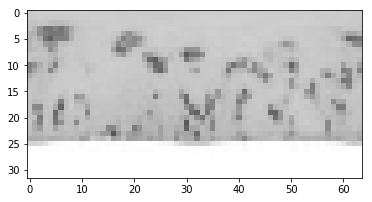

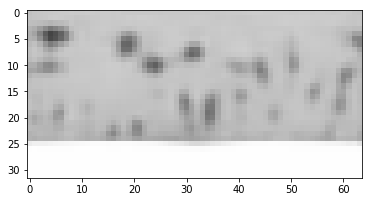

images/229.jpg


In [159]:
# Let's just view a few input images and output images

#test_images=all_directory_images_generator()

next_batch, next_filenames = next(test_images)
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])
#categories = next_batch[1]
#print(categories[0])

In [160]:
len(dict)
lookup = {}

i = 0
for key, value in dict.items():
    lookup[i]=key
    i = i+1
    
print(lookup[3])

images/229_45.jpg


In [167]:
import annoy

from annoy import AnnoyIndex
import random

f = 128
t = AnnoyIndex(f)  # Length of item vector that will be indexed

# dict holds the names and vectors
# lookup holds index and filename 

lookup = {}
i = 0
for key, value in dict.items():
    lookup[i]=key
    i = i+1

import annoy
from annoy import AnnoyIndex
import random

f = 128
t = AnnoyIndex(f)  # Length of item vector that will be indexed

for i in range(len(dict)):
    t.add_item(i,dict[lookup[i]])
    
t.build(96) # 10 trees
t.save('test.ann')

u = AnnoyIndex(f)
u.load('test.ann') # super fast, will just mmap the file
#print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

nn = u.get_nns_by_item(17, 10) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(17, i)
    print(str(i) + ' - ' + lookup[i] + ' : ' + str(distance))
    



#for index, row in df.iterrows():
#   print row['c1'], row['c2']

17 - images/233_207.jpg : 0.0
16 - images/233.jpg : 0.03225717693567276
18 - images/233_337.jpg : 0.03227583318948746
19 - images/233_83.jpg : 0.036800749599933624
83 - images/249_335.jpg : 0.05855970084667206
80 - images/249.jpg : 0.06080304831266403
82 - images/249_153.jpg : 0.060972440987825394
81 - images/249_132.jpg : 0.06261928379535675
14 - images/232_251.jpg : 0.06626598536968231
13 - images/232_202.jpg : 0.06739357858896255


In [273]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

0
0


In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [193]:

# To test the whole model
n_test_samples = 100
#n_train_samples = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
#                   20000, 30000, 40000, 50000, 60000]

n_train_samples = [10]

for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)








NameError: name 'x_train' is not defined

In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')